# bag of holding (aka. making neural networks smaller)

## setup

In [76]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm
from datetime import datetime

device = 'cuda' if t.cuda.is_available() else 'cpu'

In [58]:
batch_size = 640

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
def imshow(img):
    if img.shape[0] == 1: img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

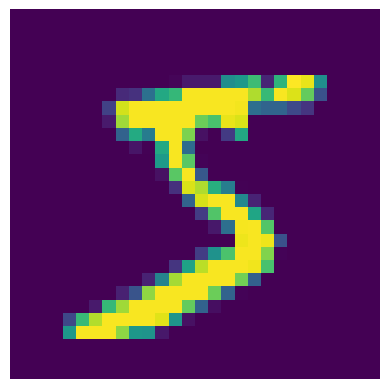

In [26]:
imshow(train_dataset[0][0])

In [60]:
class Mnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            # nn.Linear(784, 128),
            # nn.LeakyReLU(),
            # nn.Linear(128, 64),
            # nn.LeakyReLU(),
            # nn.Linear(64, 10),
            nn.Linear(784, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        return self.mlp(x.flatten(start_dim=-3))

In [66]:
@t.no_grad()
def eval(model, dataloader=test_loader):
    model.eval()
    loss, accuracy, count = 0, 0, 0
    for x, y in dataloader:
        logits = model(x.to(device))
        loss += F.cross_entropy(logits, y.to(device)).item()
        accuracy += (logits.argmax(1) == y.to(device)).sum().item()
        count += len(x)
    model.train()
    return loss / count, accuracy / count

def eval_dict(model, dataloader=test_loader, name='test'):
    loss, accuracy = eval(model, dataloader=dataloader)
    return {f'{name}_loss': loss, f'{name}_accuracy': accuracy}

# eval_dict(mnist)

In [67]:
def train(model, opt, dataloader=train_loader, wnb=True, epochs=1000):
    model.train()
    if wnb: wandb.init()
    for epoch in tqdm(range(epochs)):
        for x, y in dataloader:
            logits = model(x.to(device))
            loss = F.cross_entropy(logits, y.to(device))
            opt.zero_grad()
            loss.backward()
            opt.step()
        if epoch % 10 == 0 or epoch == epochs - 1:
            if wnb: wandb.log({'epoch': epoch} | eval_dict(model) | eval_dict(model, dataloader=train_loader, name='train'))
    if wnb: wandb.finish()

In [68]:
mnist = Mnist().to(device)
opt = optim.AdamW(mnist.parameters(), lr=3e-4)
train(mnist, opt, epochs=100)

test_accuracy,▁███
test_loss,█▁▁▁
train_accuracy,▁▇██
train_loss,█▂▁▁
test_accuracy,0.09554
test_loss,0.16852
train_accuracy,4.87234
train_loss,0.15684


100%|██████████| 100/100 [07:48<00:00,  4.69s/it]


epoch,▁▂▂▃▄▅▅▆▇▇█
test_accuracy,▁▇▇████████
test_loss,█▂▁▁▁▁▁▁▁▁▁
train_accuracy,▁▇▇▇███████
train_loss,█▂▂▁▁▁▁▁▁▁▁
epoch,99
test_accuracy,0.9667
test_loss,0.00018
train_accuracy,0.98318
train_loss,9e-05


In [75]:
t.save(mnist.state_dict(), f'weights/mnist-32-32-10_{datetime.now().strftime("%Y-%m-%d_%Hh%M")}.pt')